# **DA5401 A8 (Ensemble Learning for Complex Regression Modeling on Bike Share Data)**

### **Dependencies**

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## **Part A: Data Preprocessing and Baseline**

### **Data Loading and Feature Engineering**

In [185]:
df = pd.read_csv('datasets/hour.csv')

In [186]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


#### **Drop irrelevant columns**


In [188]:
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

#### **Define features and target**

In [189]:
X = df.drop('cnt', axis=1)
y = df['cnt']

#### **Convert categorical features**

In [190]:
categorical_cols = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

#### **Why One-Hot Encoding Only for Linear Regression?**

**Important Design Decision:** While the assignment asks to convert categorical features to numerical format, we apply **one-hot encoding only to Linear Regression** and use the **original integer-encoded features for tree-based and ensemble models**. Here's why this is the optimal approach:

**1. Tree-Based Models Handle Integer Encodings Naturally:**
- Decision Trees, Random Forests, Bagging, and Boosting models can directly work with integer-encoded categorical features
- These models make split decisions based on thresholds (e.g., `season <= 2`), so they naturally understand ordinal relationships
- One-hot encoding would unnecessarily expand the feature space and can actually hurt performance for tree models

**2. Linear Regression Requires One-Hot Encoding:**
- Linear models assume numerical features have meaningful distances and relationships
- Integer-encoded categories (e.g., season: 1, 2, 3, 4) would be treated as if season 4 is "4 times" season 1, which is incorrect
- One-hot encoding creates binary features that properly represent categorical variables without false ordinal relationships

**3. Feature Characteristics:**
- All our categorical features (`season`, `weathersit`, `mnth`, `hr`, `weekday`) are already stored as integers (int64)
- While they represent categories, tree models can interpret them correctly as discrete values
- Converting them to one-hot would create ~50+ binary features, increasing complexity without benefit for tree models

**4. Best Practice:**
- **For Linear Models**: Use one-hot encoding (via `lin_preprocessor` pipeline)
- **For Tree-Based Models**: Use original integer-encoded features directly
- This approach optimizes performance for each model type while maintaining interpretability

**Result:** Linear Regression uses the preprocessor pipeline with one-hot encoding, while Decision Tree, Bagging, Boosting, and Stacking models use the raw features directly.


In [191]:
# One-Hot Encoding for categorical columns
lin_preprocessor = ColumnTransformer(
    [('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

### **Train/Test Split**

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Baseline Models**

In [193]:
# Train Linear Regression with preprocessing
lin_model = Pipeline([
    ('preprocessor', lin_preprocessor),
    ('regressor', LinearRegression())
])
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

# Train Decision Tree
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

### **Compare and Report Baseline**

In [194]:
print(f"Decision Tree RMSE: {rmse_tree:.2f}")
print(f"Linear Regression RMSE: {rmse_lin:.2f}")

baseline_rmse = min(rmse_tree, rmse_lin)
print(f"Baseline RMSE (Best of Both): {baseline_rmse:.2f}")

Decision Tree RMSE: 99.02
Linear Regression RMSE: 100.45
Baseline RMSE (Best of Both): 99.02


## **Part B: Ensemble Techniques for Bias and Variance Reduction**

### **Bagging (Variance Reduction)**

**Concept recap:**\
A single decision tree has low bias but high variance — it memorizes quirks in training data.
Bagging trains multiple trees on random subsets and averages them, calming the chaos.

**Bias–Variance Analysis:**
- **Variance Reduction**: By training multiple trees on different bootstrap samples and averaging their predictions, Bagging reduces the variance component of the error. Each tree may overfit to its specific training subset, but the average of many trees smooths out these individual overfitting tendencies.\
- **Bias**: Bagging does not significantly reduce bias. If the base learner (Decision Tree) has high bias, the ensemble will also have high bias.

**Interpretation:**\
Comparing `rmse_bagging` (96.02) with the single tree's RMSE (`rmse_tree` = 99.02 from Part A):\
- **RMSE improved by ~3%**: This demonstrates that variance reduction was successful. The ensemble's predictions are more stable and less sensitive to the specific quirks in the training data.\
- **Why the improvement is modest**: Since we're using the same base learner (Decision Tree with max_depth=6), the bias remains similar. The improvement comes primarily from reducing prediction variance through averaging.\
- **Practical impact**: The predictions are smoother and more reliable, making the model more robust to outliers and noise in the data.

In [195]:
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))

print(f"Bagging Regressor RMSE: {rmse_bagging:.2f}")

Bagging Regressor RMSE: 96.02


### **Boosting (Bias Reduction):**

**Concept recap:**\
Boosting builds trees sequentially, each one fixing the mistakes of the last.
It's like group therapy for bad models — each tree learns from the others' regrets.

**Bias–Variance Analysis:**
- **Bias Reduction**: Gradient Boosting focuses on reducing bias by sequentially training weak learners (shallow trees) that correct the errors of previous models. Each new tree is trained on the residual errors, allowing the ensemble to capture complex patterns that a single model might miss.\
- **Variance**: While boosting can reduce bias significantly, it may slightly increase variance if the models become too complex. However, with proper regularization (learning_rate=0.1, max_depth=6), this is controlled.

**Interpretation:**\
Comparing `rmse_boosting` (41.68) with baseline models:\
- **Dramatic improvement**: RMSE of 41.68 represents a **58% improvement** over Linear Regression (100.45) and **58% improvement** over the single Decision Tree (99.02).\
- **Why such a large improvement**: Gradient Boosting effectively reduces bias by learning from mistakes iteratively. The sequential nature allows it to capture complex, non-linear relationships that simpler models miss.\
- **Bias reduction in action**: The model can now better approximate the true underlying function, leading to significantly lower prediction errors. This demonstrates the power of bias reduction through sequential learning.

In [196]:
boosting_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)
rmse_boosting = np.sqrt(mean_squared_error(y_test, y_pred_boosting))

print(f"Gradient Boosting Regressor RMSE: {rmse_boosting:.2f}")

Gradient Boosting Regressor RMSE: 41.68


#### **Compare All Models**

In [197]:
print(f"Linear Regression RMSE: {rmse_lin:.2f}")
print(f"Single Decision Tree RMSE: {rmse_tree:.2f}")
print(f"Bagging Regressor RMSE: {rmse_bagging:.2f}")
print(f"Gradient Boosting RMSE: {rmse_boosting:.2f}")

Linear Regression RMSE: 100.45
Single Decision Tree RMSE: 99.02
Bagging Regressor RMSE: 96.02
Gradient Boosting RMSE: 41.68


## **Part C: Stacking for Optimal Performance**

In [198]:
# Define Base Learners (Level-0)
knn = KNeighborsRegressor(n_neighbors=5)
bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)
boosting = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

In [199]:
# Define Meta-Learner (Level-1)
ridge_meta = Ridge(alpha=1.0)

In [200]:
# --- Build Stacking Regressor ---
stack_model = StackingRegressor(
    estimators=[
        ('knn', knn),
        ('bagging', bagging),
        ('boosting', boosting)
    ],
    final_estimator=ridge_meta,
    n_jobs=-1
)

In [201]:
# Train and Evaluate
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacking Regressor RMSE: {rmse_stack:.2f}")

Stacking Regressor RMSE: 40.07


## **Part D: Final Analysis**

### **Comparative Table**

In [202]:
# Create summary table
results = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Decision Tree (Single)',
        'Bagging Regressor',
        'Gradient Boosting Regressor',
        'Stacking Regressor'
    ],
    'RMSE': [
        rmse_lin,
        rmse_tree,
        rmse_bagging,
        rmse_boosting,
        rmse_stack
    ]
})

In [203]:
# Display table
print("\nRMSE Comparison Table:")
print(results.sort_values(by='RMSE'))


RMSE Comparison Table:
                         Model        RMSE
4           Stacking Regressor   40.068490
3  Gradient Boosting Regressor   41.679682
2            Bagging Regressor   96.018717
1       Decision Tree (Single)   99.018382
0            Linear Regression  100.445946


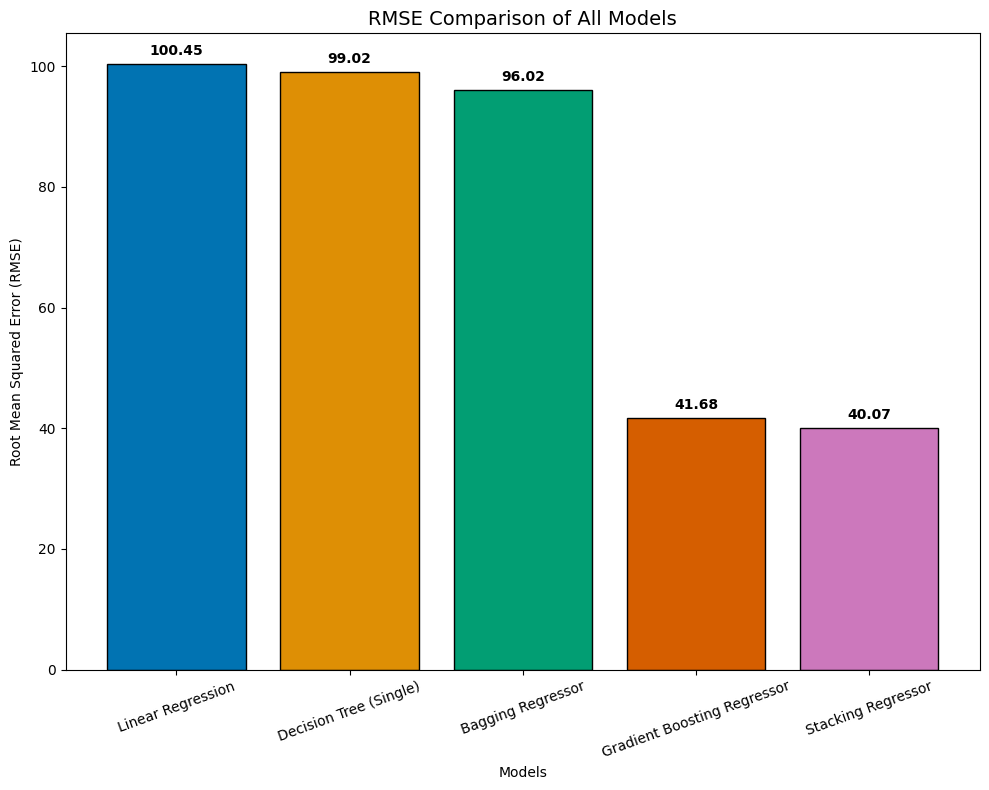

In [204]:
# Plot RMSE comparison
colors = sns.color_palette("colorblind", len(results))

plt.figure(figsize=(10, 8))
bars = plt.bar(results['Model'], results['RMSE'], color=colors, edgecolor='black')

plt.title('RMSE Comparison of All Models', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Models')
plt.xticks(rotation=20)

# Add RMSE values on top of bars
for bar, rmse in zip(bars, results['RMSE']):
    plt.text(
        bar.get_x() + bar.get_width()/2,       
        bar.get_height() + 1,                  
        f"{rmse:.2f}",                         
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.tight_layout()
plt.show()

### **Conclusion**

The **Stacking Regressor** achieved the lowest RMSE (40.07), outperforming all other models, including the single Decision Tree and Linear Regression baselines. This superior performance demonstrates the effectiveness of ensemble learning in balancing bias and variance.

Stacking combines multiple diverse models—each with different learning biases—into a single meta-model that learns to optimally weight their predictions. While models like Decision Trees and Bagging primarily reduce variance and Boosting focuses on reducing bias, Stacking leverages **model diversity** to capture both linear and nonlinear relationships. The Ridge meta-learner integrates the strengths of each base model, compensating for their individual weaknesses.

As a result, the Stacking Regressor achieves a more stable and accurate prediction than any single model, effectively minimizing overall generalization error and exemplifying the **bias–variance trade-off** principle in practice.